In [1]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from pathlib import Path
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm


#directories for train, validation and test images
train_directory = Path("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/train_another") # the training data; 5000 images of each class(damage/no damage)
validation_directory = Path("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/validation_another") #the validation data; 1000 images of each class(damage/no damage)
unbalanced_test_directory = Path("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/test_another") # 8000/1000 images of damaged/undamaged classes
balanced_test_directory = Path("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/test") # the balanced test data; 1000 images of each class(damage/no damage)

#Inialising empty lists for storing both of the damage and no_damage folders
labels_train,images_train,labels_test_another,images_test_another,labels_test,images_test = [],[],[],[],[],[]

for i in ['damage','no_damage']: 
    files_train = os.listdir(f'C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/train_another/{i}')
    files_test_another =  os.listdir(f'C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/test_another/{i}')
    files_test =  os.listdir(f'C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/test/{i}')
    images_train.append(files_train)
    images_test_another.append(files_test_another)
    images_test.append(files_test)

    for l in range(len(files_train)):
        labels_train.append(i)
    for l in range(len(files_test)):
        labels_test_another.append(i)
    for l in range(len(files_test_another)):
        labels_test.append(i)
    
print("Number of items in the training set : {}".format(len(labels_train)))
    
print("Number of items in the test_another dataset : {}".format(len(labels_test_another)))
    
print("Number of items in the test dataset : {}".format(len(labels_test)))

Number of items in the training set : 10000
Number of items in the test_another dataset : 2000
Number of items in the test dataset : 9000


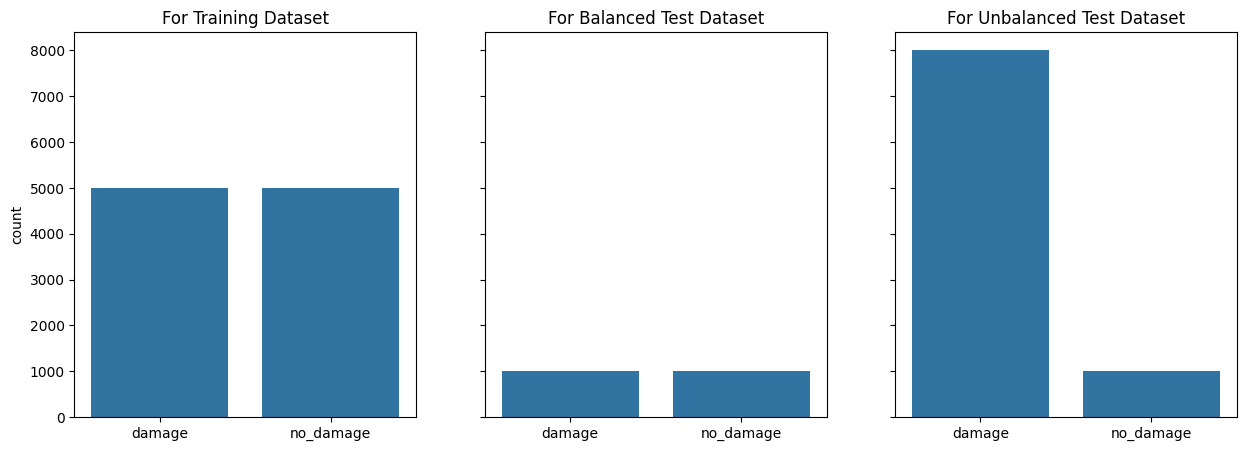

In [2]:
#Defining an instance of the LabelEncoder Class
label_en = LabelEncoder()
#Using label_en to transform the list
labels_all = [0]*3
labels_all[0] = label_en.fit_transform(labels_train)
labels_all[1] = label_en.transform(labels_test_another)
labels_all[2] = label_en.transform(labels_test)
fig,ax = plt.subplots(1,3,figsize = (15,5),sharey = True)
classes = ['damage','no_damage']
sns.countplot(x=list(labels_all[0]),ax = ax[0])
ax[0].set_title('For Training Dataset')
ax[0].set_xticks([0, 1])  # Ensure ticks match encoded labels
ax[0].set_xticklabels(classes)
# ax[0].set_ylabel('Number of Labels for each class')
sns.countplot(x=labels_all[1],ax = ax[1])
ax[1].set_xticks([0, 1])
ax[1].set_title('For Balanced Test Dataset')
# ax[1].set_ylabel('Number of Labels for each class')
ax[1].set_xticklabels(classes)
sns.countplot(x=labels_all[2],ax = ax[2])
ax[2].set_title('For Unbalanced Test Dataset')
# ax[2].set_ylabel('Number of Labels for each class')
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(classes)
plt.show()



In [3]:
import numpy as np

# Check unique values in labels
for i in range(3):
    print(f"Unique values in labels_all[{i}]:", np.unique(labels_all[i]))

Unique values in labels_all[0]: [0 1]
Unique values in labels_all[1]: [0 1]
Unique values in labels_all[2]: [0 1]


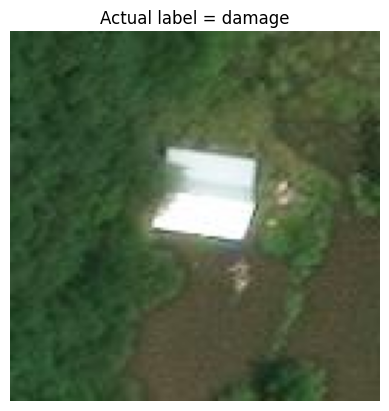

In [13]:
#quick image display with PIL
img1 = Image.open("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/train_another/damage/-93.66975_30.218802.jpeg") #train_damaged
plt.imshow(img1)
plt.title(f'Actual label = {labels_train[0]}')
plt.axis('off')
plt.show()


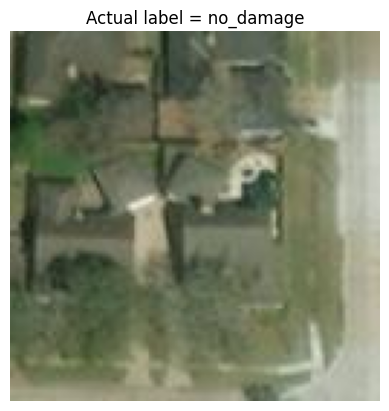

In [15]:
img2 = Image.open("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/train_another/no_damage/-95.6319_29.844140000000003.jpeg") #train_undamaged
plt.imshow(img2)
plt.title(f'Actual label = {labels_train[5000]}')
plt.axis('off')
plt.show()

Our NumPy array has the shape: (128, 128, 3)


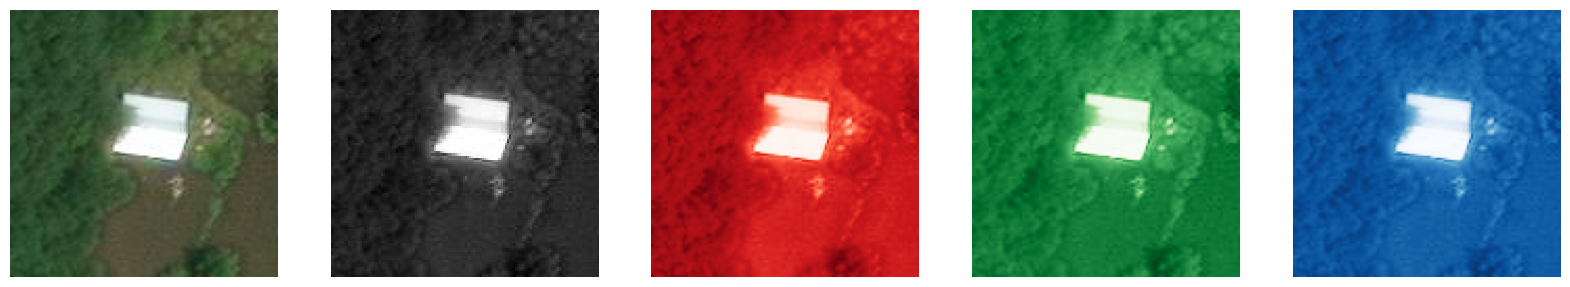

In [17]:
# Turn our image object into a NumPy array
img_data = np.array(img1)

# get the shape of the resulting array
img_data_shape = img_data.shape

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow` 
fig,ax = plt.subplots(1,5,figsize=(20,20),sharey=True)

ax[0].imshow(img_data)
ax[0].axis('off')
# grayscale image
ax[1].imshow(img_data[:,:,2], cmap='gray',interpolation='nearest')
ax[1].axis('off')
# plot the red channel
ax[2].imshow(img_data[:,:,0], cmap=plt.cm.Reds_r)
ax[2].axis('off')
# plot the green channel
ax[3].imshow(img_data[:,:,1], cmap=plt.cm.Greens_r)
ax[3].axis('off')

# plot the blue channel
ax[4].imshow(img_data[:,:,2], cmap=plt.cm.Blues_r)
ax[4].axis('off')

plt.show()

In [4]:
train_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True,# horizontal flip
        rescale=1/255.0, #re-scaling
        brightness_range=[0.2,1.2]) # brightness)
validation_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        rescale=1/255.0, #re-scaling
        brightness_range=[0.2,1.2]) # brightness)
test_unbalanced_gen =  ImageDataGenerator()
test_balanced_gen =  ImageDataGenerator()

In [5]:
train_data = train_gen.flow_from_directory(
    directory = train_directory,
    target_size = (128,128),
    class_mode = 'binary',
    color_mode='rgb',
    shuffle = True,
    batch_size=100)

val_data = validation_gen.flow_from_directory(
    directory = validation_directory,
    target_size = (128,128),
    class_mode = 'binary',
    color_mode='rgb',
    shuffle = True,
    batch_size=100)
unbalanced_data = test_unbalanced_gen.flow_from_directory(directory =unbalanced_test_directory,
                                                          target_size = (128,128),
                                                          class_mode = 'binary',
                                                          shuffle = False,
                                                          color_mode='rgb',
                                                          batch_size=100)

balanced_data = test_balanced_gen.flow_from_directory(directory =balanced_test_directory,
                                                          target_size = (128,128),
                                                          class_mode = 'binary',
                                                          color_mode='rgb',
                                                          shuffle =False,
                                                          batch_size=100)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout

# Initialize a sequential model
model = Sequential(name="Base_Model")

model.add(tensorflow.keras.layers.Input(shape=(128, 128, 3)))
model.add(Conv2D(32,kernel_size =(3, 3), activation='relu'))
model.add(Conv2D(32,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(Dense(1024,activation='relu'))

model.add(Dense(1,activation = 'sigmoid'))
# tensorflow.keras.utils.plot_model(model, "base_model.png", show_shapes=True,dpi =50)

In [24]:
# Compiling the model
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history_1 = model.fit(train_data,validation_data=val_data,epochs=10)

Epoch 1/10
100/100 [==============================] - 171s 1s/step - loss: 0.5794 - accuracy: 0.6915 - val_loss: 0.4324 - val_accuracy: 0.8230
Epoch 2/10
100/100 [==============================] - 116s 1s/step - loss: 0.3992 - accuracy: 0.8389 - val_loss: 0.3759 - val_accuracy: 0.8450
Epoch 3/10
100/100 [==============================] - 120s 1s/step - loss: 0.3220 - accuracy: 0.8716 - val_loss: 0.2915 - val_accuracy: 0.8930
Epoch 4/10
100/100 [==============================] - 121s 1s/step - loss: 0.2825 - accuracy: 0.8886 - val_loss: 0.2739 - val_accuracy: 0.8840
Epoch 5/10
100/100 [==============================] - 120s 1s/step - loss: 0.2392 - accuracy: 0.9048 - val_loss: 0.2802 - val_accuracy: 0.8900
Epoch 6/10
100/100 [==============================] - 127s 1s/step - loss: 0.2268 - accuracy: 0.9083 - val_loss: 0.2646 - val_accuracy: 0.8910
Epoch 7/10
100/100 [==============================] - 119s 1s/step - loss: 0.2130 - accuracy: 0.9141 - val_loss: 0.1916 - val_accuracy: 0.9295

In [33]:
model.save("normal_model")

INFO:tensorflow:Assets written to: normal_model\assets


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
def metrices(model) :
    y_preds_unbalanced = [1 if prob >= 0.5 else 0 for prob in model.predict(unbalanced_data)]
    y_preds_balanced = [1 if prob >= 0.5 else 0 for prob in model.predict(balanced_data)]
    y_true_unbalanced = unbalanced_data.classes
    y_true_balanced = balanced_data.classes


    precision_unbalanced = precision_score(y_true_unbalanced, y_preds_unbalanced)
    recall_unbalanced = recall_score(y_true_unbalanced, y_preds_unbalanced)
    f1_unbalanced = f1_score(y_true_unbalanced, y_preds_unbalanced)
    roc_auc_unbalanced= roc_auc_score(y_true_unbalanced, y_preds_unbalanced)

    precision_balanced = precision_score(y_true_balanced, y_preds_balanced)
    recall_balanced = recall_score(y_true_balanced, y_preds_balanced)
    f1_balanced = f1_score(y_true_balanced, y_preds_balanced)
    roc_auc_balanced = roc_auc_score(y_true_balanced, y_preds_balanced)

    print('Precision on Unbalanced Test Dataset : {}'.format(precision_unbalanced ))
    print('Precision on Balanced Test Dataset : {}'.format(precision_balanced))

    print('Recall on Unbalanced Test Dataset : {}'.format(recall_unbalanced))
    print('Recall on Balanced Test Dataset : {}'.format(recall_balanced))

    print('F1 Score on Unbalanced Test Dataset : {}'.format(f1_unbalanced))
    print('F1 Score on Balanced Test Dataset : {}'.format(f1_balanced))

    print('AUC score  on Unbalanced Test Dataset : {}'.format(roc_auc_unbalanced))
    print('AUC score on Balanced Test Dataset : {}'.format(roc_auc_balanced))
     
    return precision_unbalanced,precision_balanced, recall_unbalanced,recall_balanced,f1_unbalanced,f1_balanced ,roc_auc_unbalanced,roc_auc_balanced
    

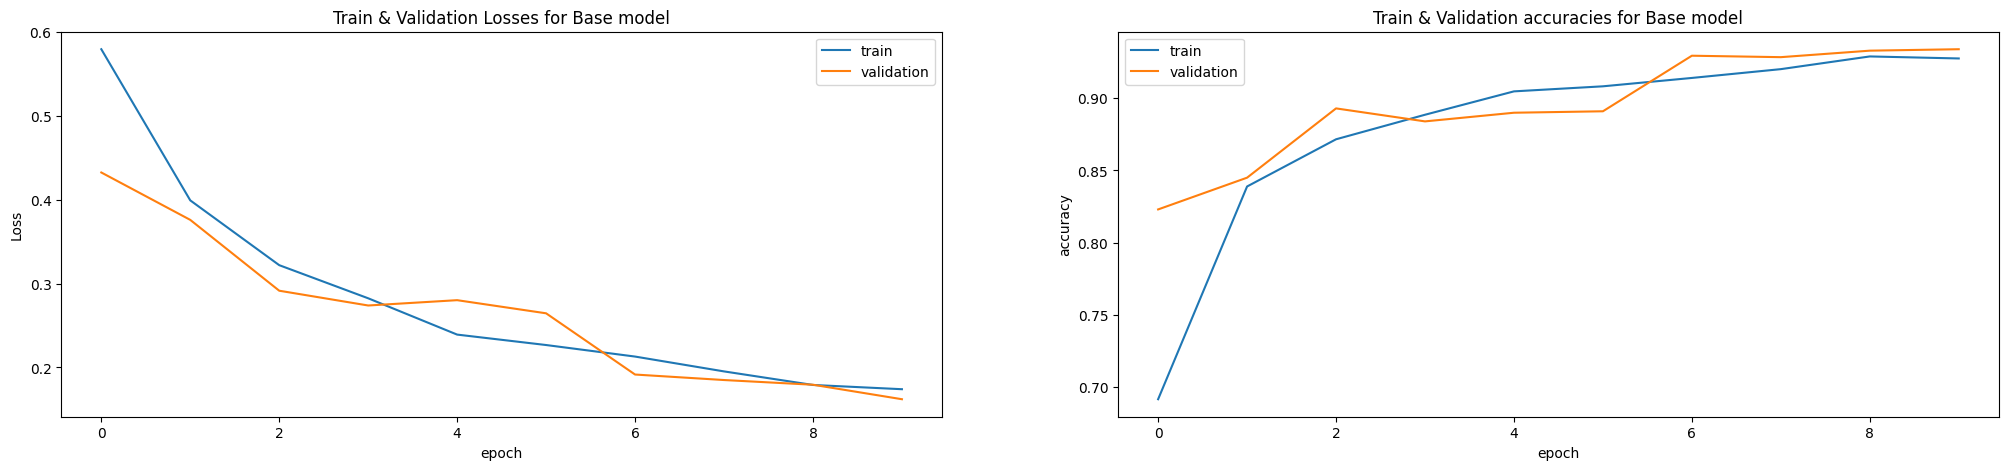

In [35]:
#plot of train loss & validation loss for the base model

fig, ax = plt.subplots(1,2,figsize = (25,5))
ax[0].plot(history_1.history['loss'])
ax[0].plot(history_1.history['val_loss'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train & Validation Losses for Base model')

#plot of train accuracy & validation accuracy for the base model

ax[1].plot(history_1.history['accuracy'])
ax[1].plot(history_1.history['val_accuracy'])
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Train & Validation accuracies for Base model')

plt.show()

In [37]:
test_unbalanced_acc_1 = model.evaluate(unbalanced_data,verbose=0)
print('Test Accuracy of Specified Base Model on Unbalanced Test Dataset : {}'.format(test_unbalanced_acc_1[1] ))
test_balanced_acc_1= model.evaluate(balanced_data,verbose =0)
print('Test Accuracy of Specified Base Model on Balanced Test Dataset : {}'.format(test_balanced_acc_1[1] ))

metrics_1 = metrices(model)

Test Accuracy of Specified Base Model on Unbalanced Test Dataset : 0.964555561542511
Test Accuracy of Specified Base Model on Balanced Test Dataset : 0.8939999938011169
Precision on Unbalanced Test Dataset : 0.857292759706191
Precision on Balanced Test Dataset : 0.9769975786924939
Recall on Unbalanced Test Dataset : 0.817
Recall on Balanced Test Dataset : 0.807
F1 Score on Unbalanced Test Dataset : 0.8366615463389657
F1 Score on Balanced Test Dataset : 0.8838992332968236
AUC score  on Unbalanced Test Dataset : 0.9
AUC score on Balanced Test Dataset : 0.894


In [38]:
val_img1 = Image.open("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/validation_another/damage/-93.955831_30.1334.jpeg")
val_img2 = Image.open("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/validation_another/damage/-93.799735_30.036396000000003.jpeg")
val_img3 = Image.open("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/validation_another/no_damage/-95.067337_29.831393.jpeg")
val_img4 = Image.open("C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/validation_another/no_damage/-95.64264_29.844161.jpeg")
val_img_labels = [0,0,1,1]
val_imgs = [val_img1,val_img2,val_img3,val_img4]

In [39]:
val_img_data = []
for img_data in val_imgs:
    data = np.array(img_data)
    data = data/255.0
    data = np.expand_dims(data,axis=0)
    #print(data.shape)
    val_img_data.append(data)

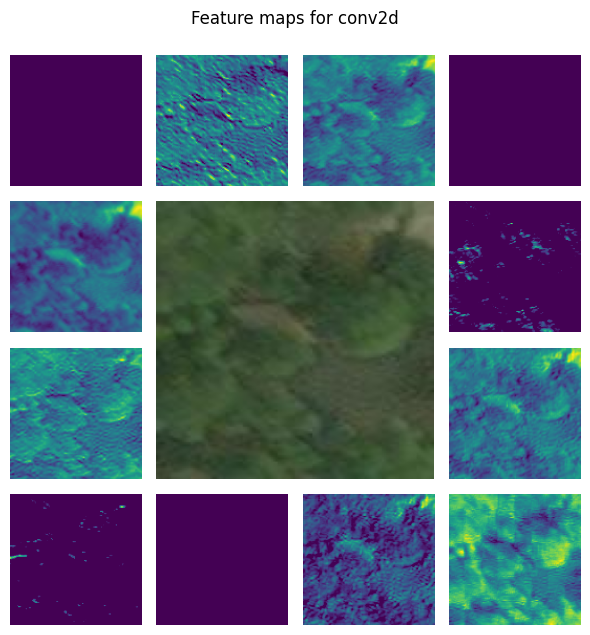

In [40]:
#Helper function used to plot the activation maps
def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    axbig.imshow(img.squeeze())
    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i])
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',y=1.05);

first_conv_layer_output = model.layers[0].output
activation_model = Model(inputs=model.layers[0].input,outputs=first_conv_layer_output)
activations = activation_model.predict(val_img_data[0])
plot_featuremaps(val_img_data[0],activations,[model.layers[0].name])

In [41]:
#Defining score function for saliency maps and GradCAM heatmap
def score_function(index):
    if (index==0 or index==1):
        score = BinaryScore(0.0)
    else:
        score = BinaryScore(1.0)
    return score

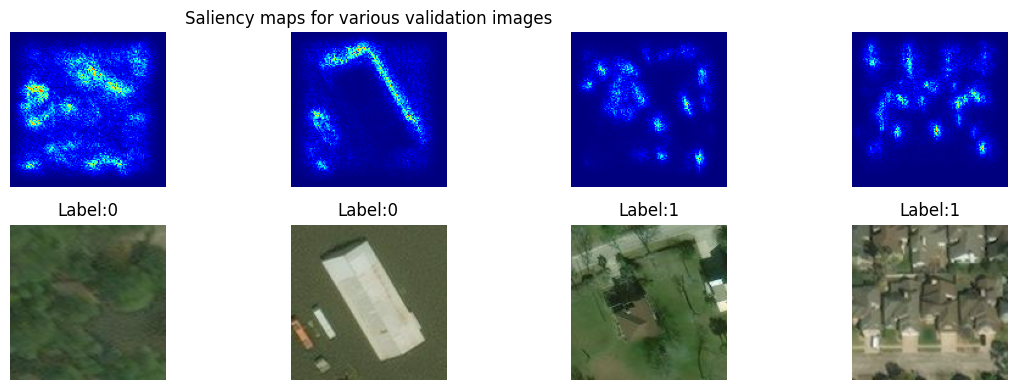

In [42]:
fig,ax = plt.subplots(2,4,figsize=(12, 4))

for i in range(4):
    saliency_model = Saliency(model,model_modifier=ReplaceToLinear(),clone=True)
    saliency_map = saliency_model(score_function(i),val_img_data[i])
    
    ax[1,i].imshow(val_imgs[i])
    ax[1,i].set_title(f'Label:{val_img_labels[i]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(saliency_map[0], cmap='jet')
    ax[0,1].set_title('Saliency maps for various validation images')
    ax[0,i].axis('off')

plt.tight_layout()
plt.show()

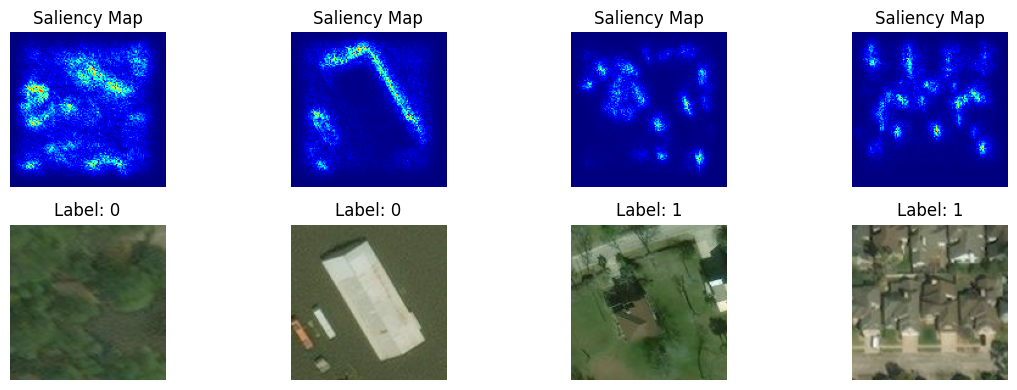

In [43]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.saliency import Saliency

# Manually modify the model's output to have a linear activation
def model_modifier_function(m):
    m.layers[-1].activation = tensorflow.keras.activations.linear

# Define saliency model with the modified model
saliency_model = Saliency(model, model_modifier=model_modifier_function, clone=True)

# Define a function to extract predictions
def score_function(index):
    return lambda output: output[:, index]

fig, ax = plt.subplots(2, 4, figsize=(12, 4))

for i in range(4):
    # Compute saliency map
    saliency_map = saliency_model(score_function(0), val_img_data[i])  # Adjust index as needed

    # Display original image
    ax[1, i].imshow(val_imgs[i])
    ax[1, i].set_title(f'Label: {val_img_labels[i]}')
    ax[1, i].axis('off')

    # Display saliency map
    ax[0, i].imshow(saliency_map[0], cmap='jet')
    ax[0, i].set_title('Saliency Map')
    ax[0, i].axis('off')

plt.tight_layout()
plt.show()


InvalidArgumentError: slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

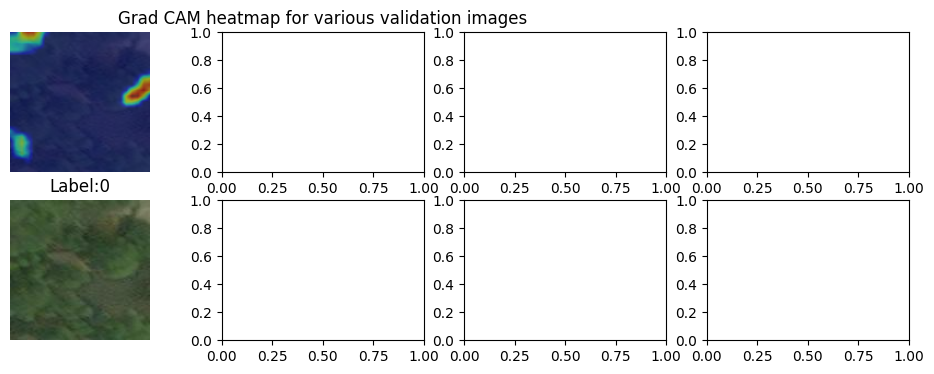

In [44]:
fig,ax = plt.subplots(2,4,figsize=(12, 4))

for i in range(4):
    gradcam = Gradcam(model,model_modifier=ReplaceToLinear(),clone=True)
    cam = gradcam(score_function(i),val_img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(val_imgs[i])
    ax[1,i].set_title(f'Label:{val_img_labels[i]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(val_img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    ax[0,1].set_title('Grad CAM heatmap for various validation images')
    ax[0,i].axis('off')

plt.tight_layout()
plt.show()

ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (1, 1)

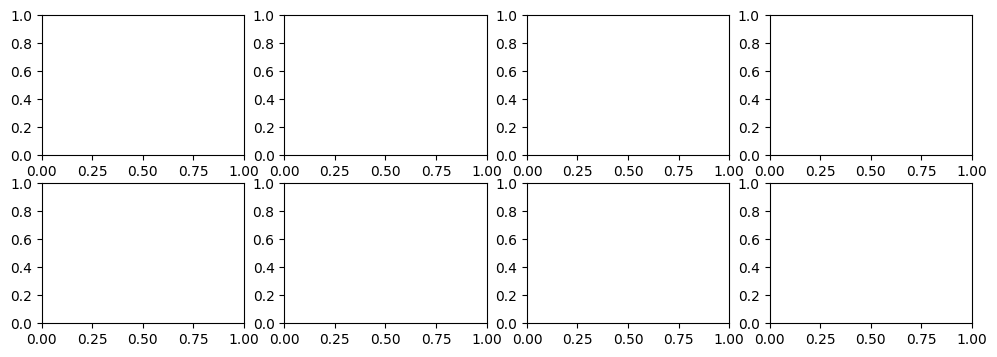

In [51]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow.keras.backend as K

# Define a model modifier function to replace the last layer's activation with linear
def model_modifier_function(m):
    m.layers[-1].activation = K.function([m.input], [m.output])  # Set activation to linear

# Define GradCAM model with the modified model
gradcam = Gradcam(model, model_modifier=model_modifier_function, clone=True)

# Define a function to extract predictions
def score_function(index):
    return lambda output: output[:, index]

fig, ax = plt.subplots(2, 4, figsize=(12, 4))

for i in range(4):
    # Compute Grad-CAM heatmap
    cam = gradcam(score_function(0), val_img_data[i])  # Adjust index as needed

    # Normalize heatmap
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    # Display original image
    ax[1, i].imshow(val_imgs[i])
    ax[1, i].set_title(f'Label: {val_img_labels[i]}')
    ax[1, i].axis('off')

    # Display Grad-CAM heatmap
    ax[0, i].imshow(val_img_data[i][0])  # Original image
    ax[0, i].imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    ax[0, i].set_title('Grad-CAM Heatmap')
    ax[0, i].axis('off')

plt.tight_layout()
plt.show()


InvalidArgumentError: slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

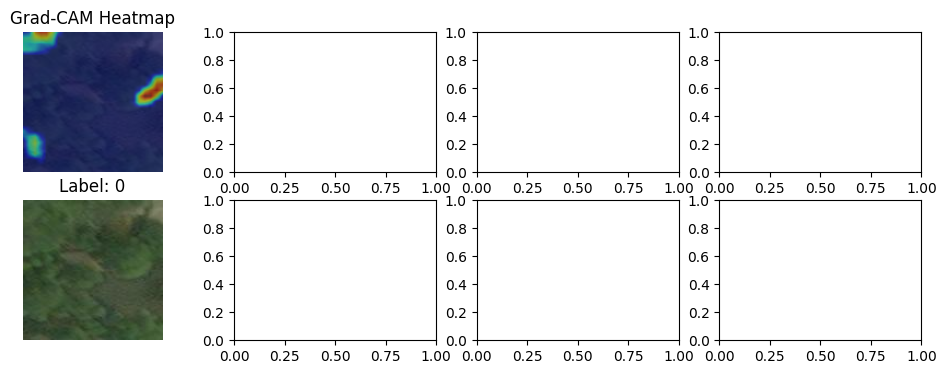

In [54]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

# Modify the model's last activation layer manually
def model_modifier_function(m):
    m.layers[-1].activation = tf.keras.activations.linear  # Set activation to linear

# Initialize Grad-CAM with the modified model
gradcam = Gradcam(model, model_modifier=model_modifier_function, clone=True)

# Function to define the target class for Grad-CAM
def score_function(index):
    return lambda output: output[:, index]

fig, ax = plt.subplots(2, 4, figsize=(12, 4))

for i in range(4):
    # Compute Grad-CAM heatmap
    cam = gradcam(score_function(i), val_img_data[i])  

    # Normalize heatmap
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    # Display original image
    ax[1, i].imshow(val_imgs[i])
    ax[1, i].set_title(f'Label: {val_img_labels[i]}')
    ax[1, i].axis('off')

    # Display Grad-CAM heatmap
    ax[0, i].imshow(val_img_data[i][0])  # Original image
    ax[0, i].imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    ax[0, i].set_title('Grad-CAM Heatmap')
    ax[0, i].axis('off')

plt.tight_layout()
plt.show()


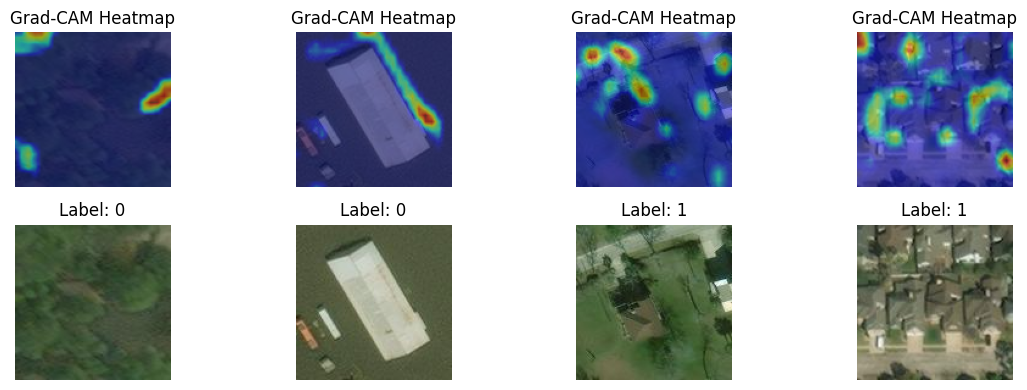

In [56]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

# Modify the last layer to linear activation
def model_modifier_function(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Initialize Grad-CAM
gradcam = Gradcam(model, model_modifier=model_modifier_function, clone=True)

# Modify the function based on your model output type
if model.output_shape[-1] == 1:  # Binary classification
    def score_function(index):
        return lambda output: output[:, 0]  # Always extract the only output neuron
else:  # Multi-class classification
    def score_function(index):
        return lambda output: output[:, index]  # Extract probability for class `index`

fig, ax = plt.subplots(2, 4, figsize=(12, 4))

for i in range(4):
    cam = gradcam(score_function(i), val_img_data[i])  # Compute Grad-CAM heatmap

    # Normalize heatmap
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    # Display original image
    ax[1, i].imshow(val_imgs[i])
    ax[1, i].set_title(f'Label: {val_img_labels[i]}')
    ax[1, i].axis('off')

    # Display Grad-CAM heatmap
    ax[0, i].imshow(val_img_data[i][0])  # Original image
    ax[0, i].imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    ax[0, i].set_title('Grad-CAM Heatmap')
    ax[0, i].axis('off')

plt.tight_layout()
plt.show()


In [17]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten
from tensorflow.keras import regularizers
# Initialize a sequential model
model_reg = Sequential(name="Regularized_Model")


model_reg.add(Conv2D(32,kernel_size =(3, 3), activation='relu',input_shape=(128,128,3)))
model_reg.add(Conv2D(32,kernel_size =(3,3), activation='relu'))
model_reg.add(BatchNormalization())
model_reg.add(MaxPool2D(pool_size=(2, 2)))
model_reg.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model_reg.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model_reg.add(BatchNormalization())
model_reg.add(MaxPool2D(pool_size=(2, 2)))
model_reg.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model_reg.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model_reg.add(BatchNormalization())
model_reg.add(MaxPool2D(pool_size=(2, 2)))

model_reg.add(Flatten())

model_reg.add(Dense(1024,activation='relu'))
model_reg.add(Dropout(0.05))
model_reg.add(Dense(1024,activation='relu'))
model_reg.add(Dropout(0.05))

model_reg.add(Dense(1,activation = 'sigmoid'))

In [19]:
# Compiling the model
model_reg.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
history_2 = model_reg.fit(train_data,validation_data=val_data,epochs=15)

Epoch 1/15
100/100 [==============================] - 197s 2s/step - loss: 0.5200 - accuracy: 0.7650 - val_loss: 0.6942 - val_accuracy: 0.5010
Epoch 2/15
100/100 [==============================] - 146s 1s/step - loss: 0.3237 - accuracy: 0.8621 - val_loss: 1.7385 - val_accuracy: 0.5000
Epoch 3/15
100/100 [==============================] - 134s 1s/step - loss: 0.2706 - accuracy: 0.8889 - val_loss: 1.0528 - val_accuracy: 0.5000
Epoch 4/15
100/100 [==============================] - 132s 1s/step - loss: 0.2365 - accuracy: 0.9040 - val_loss: 1.4957 - val_accuracy: 0.4985
Epoch 5/15
100/100 [==============================] - 128s 1s/step - loss: 0.2090 - accuracy: 0.9136 - val_loss: 1.1358 - val_accuracy: 0.5025
Epoch 6/15
100/100 [==============================] - 129s 1s/step - loss: 0.1964 - accuracy: 0.9185 - val_loss: 0.6389 - val_accuracy: 0.7115
Epoch 7/15
100/100 [==============================] - 133s 1s/step - loss: 0.1826 - accuracy: 0.9226 - val_loss: 0.4364 - val_accuracy: 0.8235

In [23]:
model_reg.save("regularised_model")

INFO:tensorflow:Assets written to: regularised_model\assets


NameError: name 'history_1' is not defined

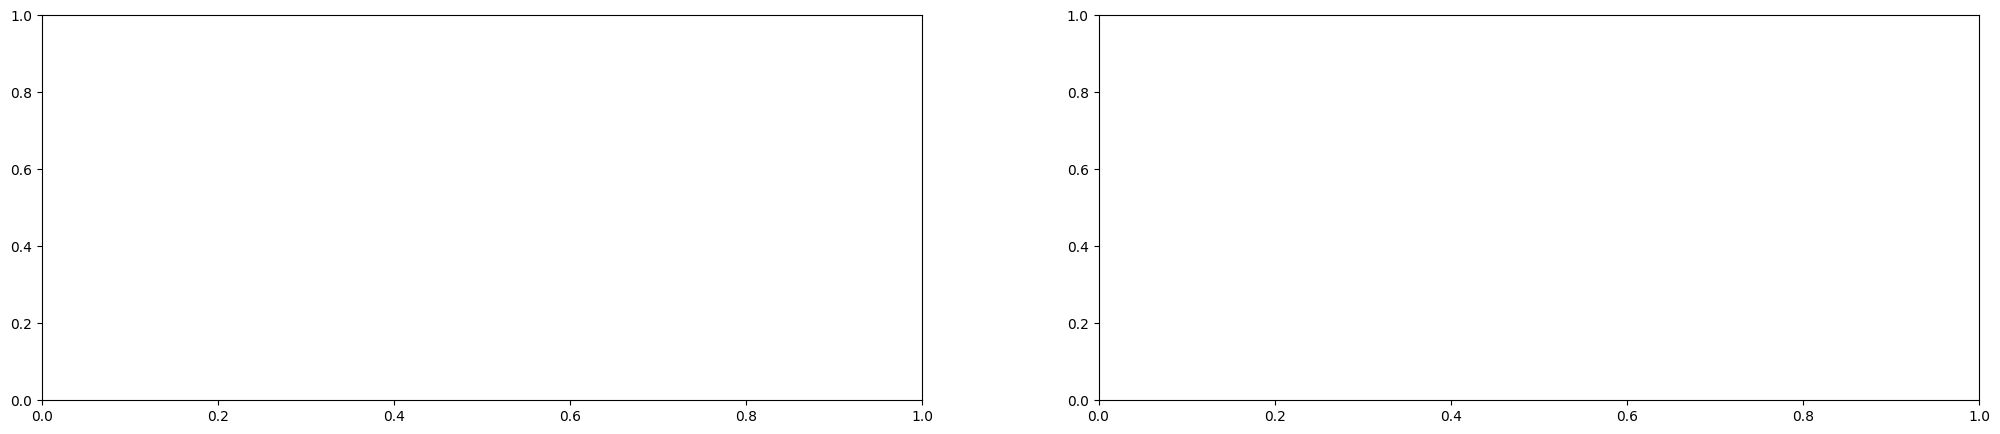

In [24]:
#Loss plots of Regularized and base model


fig, ax = plt.subplots(1,2,figsize = (25,5))
ax[0].plot(history_1.history['loss'])
ax[0].plot(history_1.history['val_loss'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss for Base')

ax[1].plot(history_2.history['loss'])
ax[1].plot(history_2.history['val_loss'])
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss for Regularized')

NameError: name 'history_1' is not defined

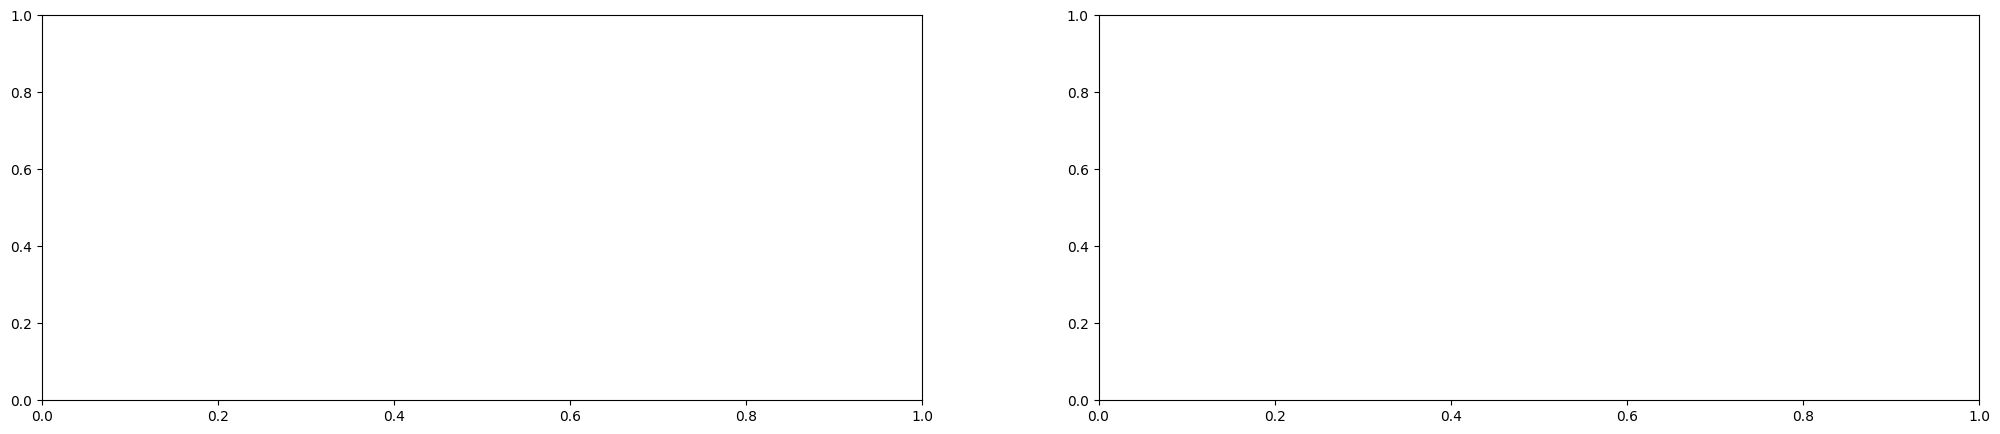

In [27]:
#Accuracy plots of Regularized and base model

fig, ax = plt.subplots(1,2,figsize = (25,5))
ax[0].plot(history_1.history['accuracy'])
ax[0].plot(history_1.history['val_accuracy'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].set_title('model accuracy for Base')

ax[1].plot(history_2.history['accuracy'])
ax[1].plot(history_2.history['val_accuracy'])
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('model accuracy for Regularized')


plt.show()

In [34]:
test_unbalanced_acc_2 = model_reg.evaluate(unbalanced_data,verbose=0)
print('Test Accuracy of Regularised Model on Unbalanced Test Dataset : {}'.format(test_unbalanced_acc_2[1] ))
test_balanced_acc_2= model_reg.evaluate(balanced_data,verbose =0)
print('Test Accuracy of Regularised Model on Balanced Test Dataset : {}'.format(test_balanced_acc_2[1] ))

metrics_2 = metrices(model_reg)

Test Accuracy of Regularised Model on Unbalanced Test Dataset : 0.8274444341659546
Test Accuracy of Regularised Model on Balanced Test Dataset : 0.8730000257492065
Precision on Unbalanced Test Dataset : 0.3870044953003678
Precision on Balanced Test Dataset : 0.8226643598615917
Recall on Unbalanced Test Dataset : 0.947
Recall on Balanced Test Dataset : 0.951
F1 Score on Unbalanced Test Dataset : 0.549463301421526
F1 Score on Balanced Test Dataset : 0.8821892393320965
AUC score  on Unbalanced Test Dataset : 0.87975
AUC score on Balanced Test Dataset : 0.8730000000000001


In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def preprocess_image(image_path):
    # Load the image and resize it to match the model's input shape
    img = load_img(image_path, target_size=(128, 128))  
    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = img_array / 255.0  # Normalize pixel values to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [56]:
image_path="C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/validation_another/no_damage/-95.083167_30.017446999999997.jpeg"
image_path_d="C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/validation_another/damage/-95.62233_29.784067999999998.jpeg"
processed_image = preprocess_image(image_path)
processed_image_d = preprocess_image(image_path_d)

In [60]:
prediction = model_reg.predict(processed_image)

# Output prediction result
if prediction[0][0] > 0.5:
    print("Predicted: not damaged")
else:
    print("Predicted: damaged")
    

Predicted: not damaged


In [58]:
prediction = model_reg.predict(processed_image_d)

# Output prediction result
if prediction[0][0] > 0.5:
    print("Predicted: not damaged")
else:
    print("Predicted: damaged")
    

Predicted: not damaged


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

In [18]:
model_hybrid = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])


In [21]:
model_hybrid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_hybrid.fit(train_data, validation_data=val_data, epochs=15)

Epoch 1/15
100/100 [==============================] - 142s 1s/step - loss: 0.7016 - accuracy: 0.5119 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 2/15
100/100 [==============================] - 116s 1s/step - loss: 0.6909 - accuracy: 0.5289 - val_loss: 0.6768 - val_accuracy: 0.5915
Epoch 3/15
100/100 [==============================] - 124s 1s/step - loss: 0.6803 - accuracy: 0.5653 - val_loss: 0.6765 - val_accuracy: 0.5710
Epoch 4/15
100/100 [==============================] - 112s 1s/step - loss: 0.6753 - accuracy: 0.5772 - val_loss: 0.6799 - val_accuracy: 0.5630
Epoch 5/15
100/100 [==============================] - 107s 1s/step - loss: 0.6752 - accuracy: 0.5779 - val_loss: 0.6637 - val_accuracy: 0.6045
Epoch 6/15
100/100 [==============================] - 111s 1s/step - loss: 0.6685 - accuracy: 0.5872 - val_loss: 0.6686 - val_accuracy: 0.5920
Epoch 7/15
100/100 [==============================] - 108s 1s/step - loss: 0.6656 - accuracy: 0.5895 - val_loss: 0.6489 - val_accuracy: 0.6290

In [23]:
model_hybrid.save("RESNETT_CNN_model")

INFO:tensorflow:Assets written to: RESNETT_CNN_model\assets


C:\Users\deepa\anaconda3\envs\jupyter_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [79]:
prediction = model_hybrid.predict(processed_image_d)

# Output prediction result
if prediction[0][0] > 0.5:
    print("Predicted: not damaged")
else:
    print("Predicted: damaged")
    

Predicted: damaged


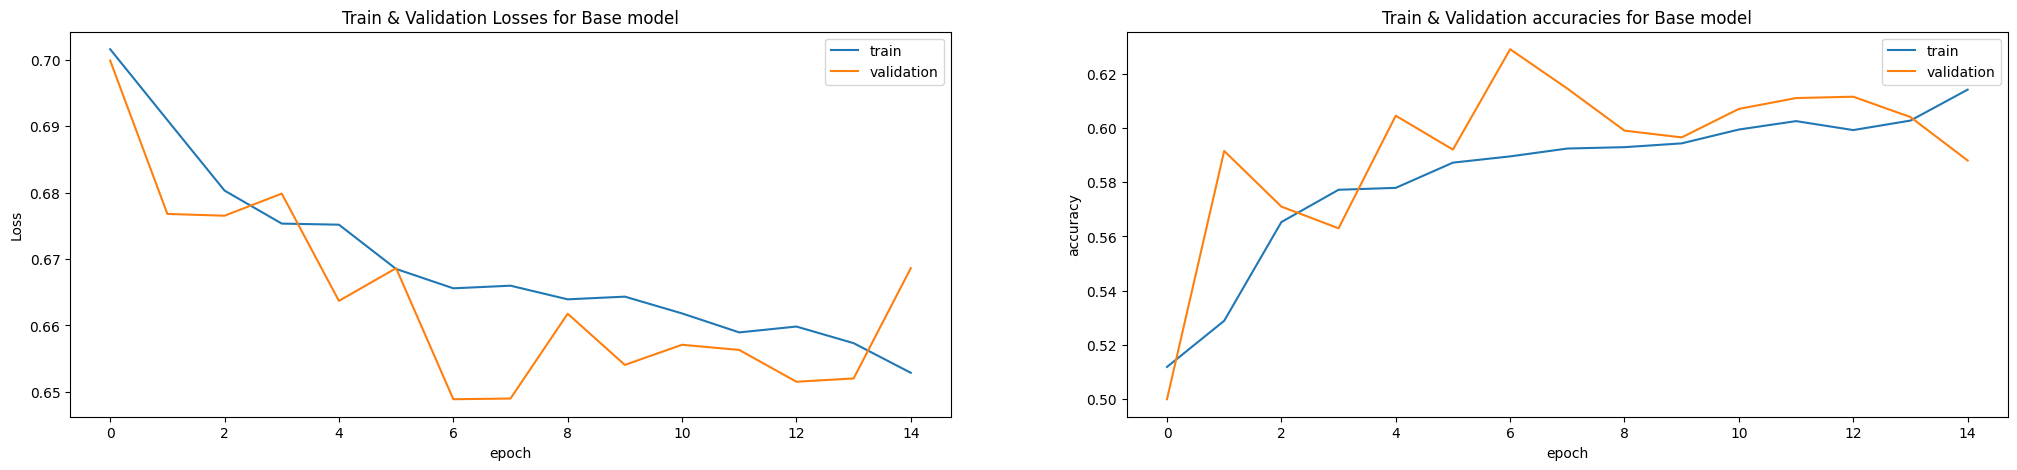

In [24]:
#plot of train loss & validation loss for the base model

fig, ax = plt.subplots(1,2,figsize = (25,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train & Validation Losses for Base model')

#plot of train accuracy & validation accuracy for the base model

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Train & Validation accuracies for Base model')

plt.show()

In [83]:
test_unbalanced_acc_3 = model_hybrid.evaluate(unbalanced_data,verbose=0)
print('Test Accuracy of Regularised Model on Unbalanced Test Dataset : {}'.format(test_unbalanced_acc_3[1] ))
test_balanced_acc_3= model_hybrid.evaluate(balanced_data,verbose =0)
print('Test Accuracy of Regularised Model on Balanced Test Dataset : {}'.format(test_balanced_acc_3[1] ))

metrics_3 = metrices(model_hybrid)

Test Accuracy of Regularised Model on Unbalanced Test Dataset : 0.11133333295583725
Test Accuracy of Regularised Model on Balanced Test Dataset : 0.4959999918937683
Precision on Unbalanced Test Dataset : 0.11070315976858033
Precision on Balanced Test Dataset : 0.49798590130916415
Recall on Unbalanced Test Dataset : 0.995
Recall on Balanced Test Dataset : 0.989
F1 Score on Unbalanced Test Dataset : 0.19923908690428513
F1 Score on Balanced Test Dataset : 0.6624246483590087
AUC score  on Unbalanced Test Dataset : 0.4979375
AUC score on Balanced Test Dataset : 0.496


In [31]:
test_dir = "C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/test"

# Create a test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),  # Match model input size
    batch_size=32,
    label_mode="int"  # "int" for integer labels (0,1), use "categorical" for one-hot encoding
)

# Evaluate the model on test dataset
loss, accuracy = model_hybrid.evaluate(test_dataset)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.2%}")

Found 2000 files belonging to 2 classes.
63/63 [==============================] - 6s 91ms/step - loss: 12.9049 - accuracy: 0.5000
Test Loss: 12.9049
Test Accuracy: 50.00%


In [25]:
test_dir = "C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/test"

# Create a test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),  # Match model input size
    batch_size=32,
    label_mode="int"  # "int" for integer labels (0,1), use "categorical" for one-hot encoding
)

# Evaluate the model on test dataset
loss, accuracy = model_hybrid.evaluate(test_dataset)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.2%}")

Found 2000 files belonging to 2 classes.
63/63 [==============================] - 14s 141ms/step - loss: 12.9049 - accuracy: 0.5000
Test Loss: 12.9049
Test Accuracy: 50.00%


In [35]:
from tensorflow.keras.models import load_model
model = load_model("regularised_model")

In [39]:
test_dir = "C:/Users/deepa/Desktop/jupyter-pr/DL_PROJECT/test_2/test"

# Create a test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),  # Match model input size
    batch_size=32,
    label_mode="int"  # "int" for integer labels (0,1), use "categorical" for one-hot encoding
)

# Evaluate the model on test dataset
loss, accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.2%}")

Found 2000 files belonging to 2 classes.
63/63 [==============================] - 6s 97ms/step - loss: 6.4415 - accuracy: 0.4965
Test Loss: 6.4415
Test Accuracy: 49.65%


In [41]:
model = load_model("normal_model")

In [43]:
loss, accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.2%}")

63/63 [==============================] - 5s 42ms/step - loss: 14.2723 - accuracy: 0.9010
Test Loss: 14.2723
Test Accuracy: 90.10%
